# Embedding model

In [1]:
import tensorflow as tf
import numpy as np
from scipy import spatial

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_embmod_grt = global_run_tests
global_run_tests = False

%run dataset.ipynb
%run visualisation.ipynb

global_run_tests = _embmod_grt

_embed_model = None

In [9]:
class EmbeddingModel():
    GpuMemoryFraction = .9
    
    def __init__(self, dataset, embed_dims, batch_size):
        self.data       = dataset
        self.embed_dims = embed_dims
        self.batch_size = batch_size
        self._session   = None
        self._graph     = None
        self._is_loaded = False
        self._is_built  = False
        self._has_probs = False
        
    def _embedding_nn(self, images, out_dim):
        def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs=inputs,
                filters=filters,
                kernel_size=kernel_size,
                padding=padding,
                activation=tf.nn.relu)
            return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = images
        l = conv2d_maxpool(l, 16)
        l = conv2d_maxpool(l, 32)
        l = conv2d_maxpool(l, 64)
        l = conv2d_maxpool(l, 128)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=out_dim)
        return l

    def tsne_loss(self, P, batch_size, dims, activations):
        d = dims
        n = batch_size
        v = d - 1.

        eps = 10e-15
        sum_act = tf.reduce_sum(tf.square(activations), axis=1)
        Q = tf.reshape(sum_act, [-1, 1]) + -2 * tf.matmul(activations, activations, transpose_b=True)
        Q = (sum_act + Q) / v
        Q = tf.pow(1 + Q, -(v + 1) / 2)
        Q *= (1 - tf.eye(n))
        Q /= tf.reduce_sum(Q)
        Q = tf.maximum(Q, eps)
        C = tf.log((P + eps) / (Q + eps))
        C = tf.reduce_mean(P * C) * 10000000
        return C

    def build(self, joint_probs):
        assert self.data.data_size>0, "Model data is not loaded"
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        data_size   = self.data.data_size
        self.joint_probs = joint_probs
        with self._graph.as_default(), tf.name_scope('embedding'), tf.device('/gpu:0'):
            # placeholders
            self.images_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='images')
            self.probs_pl   = tf.placeholder(dtype=tf.float32, shape=self.joint_probs.shape[-2:], name='probs')
            self.lr_pl      = tf.placeholder(dtype=tf.float32, name='lr')
            # operations
            self.embed_op   = self._embedding_nn(self.images_pl, self.embed_dims)
            self.loss_op    = self.tsne_loss(self.probs_pl, self.batch_size, self.embed_dims, self.embed_op)
            self.train_op   = tf.train.AdamOptimizer(1e-4).minimize(self.loss_op)
            self.init_op    = tf.global_variables_initializer()
        self._is_built = True
        
    def train(self, step_num, learning_rate = 1e-4, log_every=10):
        assert self._is_built, "Model is not built"
        
        if self._session:
            self._session.close()
        gpu_options   = tf.GPUOptions(per_process_gpu_memory_fraction=self.GpuMemoryFraction)
        self._session = tf.Session(graph=self._graph, config=tf.ConfigProto(gpu_options=gpu_options))
        self._session.run(self.init_op)
            
        def get_next_batch(i, bs):
            imgs = self.data.train_images[i:i+bs]
            i = i + bs
            if i >= self.data.data_size:
                i = 0
            return i, imgs
        
        try:
            losses   = []
            i = 0
            for step in range(step_num):
                pi = i//self.batch_size
                i, images = get_next_batch(i, self.batch_size)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.images_pl: images,
                    self.probs_pl : self.joint_probs[pi],
                    self.lr_pl    : learning_rate,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, 0)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, 0)
        
    def embed_images(self, imgs):
        embeds = np.zeros(shape=[len(imgs), self.embed_dims])
        bs = min(len(imgs), self.batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            embeds[i*bs:(i+1)*bs,:] = self._session.run(self.embed_op, feed_dict = {self.images_pl : batch})
        return embeds

## Test train

In [1]:
%%time
def test_train_model(image_shape, step_num, learning_rate, embed_dims):
    joint_similarity = np.load("data/joint_similarity.npy")
    plt.imshow(joint_similarity**.1, cmap='gray')
    plt.show()
    
    data_size  = len(joint_similarity)
    batch_size = data_size
    
    data = Dataset(image_shape)
    data.load(_dataset_path, data_size)
    
    model = EmbeddingModel(data, embed_dims, batch_size)
    model.build([joint_probs])
    model.train(step_num)
    return model

if global_run_tests:
    _emb_model = test_train_model(
        image_shape   = [128,128,1],
        step_num      = 500, 
        learning_rate = 1e-4, 
        embed_dims    = 30)

NameError: name 'global_run_tests' is not defined

## Test embedding

find_nearest ...
database: [1000, 30]
targets:  [32, 30]


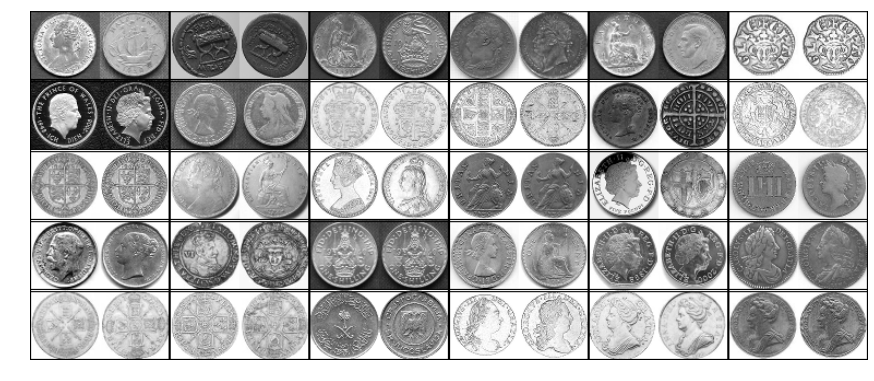

CPU times: user 824 ms, sys: 168 ms, total: 992 ms
Wall time: 861 ms


In [4]:
%%time
def find_nearest(database, targets):
    tree = spatial.KDTree(database)
    results = tree.query(targets)
    return results[1], results[0]

def show_nearest(targets, nearest, num):
    _,h,w,_ = targets.shape
    img1 = targets.reshape([num*h,w])
    img2 = nearest.reshape([num*h,w])
    img1[:,0]   = 0
    img2[:,w-1] = 0
    sheet = np.concatenate([img1, img2], axis=1)
    sheet[np.arange(0,h*num,h)-1,:] = 0
    sheet[np.arange(0,h*num,h)+1,:] = 0
    cols = 6
    show_images(images=sheet, image_shape=[h, 2*w], cols=cols, rows=num//cols)

def test_embedding(model, num):
    assert model, "Model is not defined"
    
    aug  = Augmentator(cache_size = 42)
    rate = .5
    
    per = np.arange(model.data.data_size)
    np.random.shuffle(per)
    
    database_images = model.data.test_images
    target_images   = model.data.test_images[per][:num]
    
    for i in range(len(database_images)):
        database_images[i] = aug.augment(database_images[i], rate=0)
    for i in range(len(target_images)):
        target_images[i] = aug.augment(target_images[i], rate=rate)
    
    database = model.embed_images(database_images)
    
    targets = model.embed_images(target_images)
    
    nearests, distances = find_nearest(database, targets)
    nearest_images = database_images[nearests]
    
    print("database:", list(database.shape))
    print("targets :", list(targets.shape))
    show_nearest(target_images, nearest_images, num)

if global_run_tests:
    test_embedding(_emb_model, 32)